# Web Scraping using Requests and BeautifulSoup


Web scraping is the process of automatically extracting data from websites and converting it into a structured format (like CSV, Excel, or a database) so it can be analyzed or reused.

Websites contain huge amounts of data, but most of it is:
- Unstructured (HTML pages)
- Not directly downloadable

## Web Scraping Architecture / Working 
Steps:

- Send HTTP request to server

- Receive HTML response

- Parse HTML (DOM tree)

- Extract required elements

- Store extracted data


### HTTP Methods Used in Scraping

| Method | Description            |
| ------ | ---------------------- |
| GET    | Retrieve web page data |
| POST   | Send form data         |





## Types of Web Scraping

- Static Web Scraping :
    Static web scraping is the process of extracting data from websites where the content is directly available in the HTML source code returned by the server.
    Tools like `request`, `BeautifulSoup`, `lxml` is used for scrapping.

- Dynamic Web Scraping :
    Dynamic web scraping extracts data from websites where the content is generated or loaded using JavaScript after the page loads. The data is not visible in the initial HTML source.
    Tools like `Selenium` , `Playwright` is used for scrapping. Here, the webpage is simulate as user actions.

- API-Based Scraping :
    API-based scraping involves directly accessing data through official APIs provided by websites instead of scraping HTML pages.
    Data is returned in structured formats such as JSON or XML.
 

## Step 1:
Begin by importing the essential libraries.

- `requests` is used for sending HTTP requests to fetch web pages. 
- `BeautifulSoup` parses the HTML response into a navigable structure. 
- We also import `time` for implementing delays, `csv` for data export, and `pandas` for advanced data manipulation and analysis of scraped content.

In [6]:
!pip install beautifulsoup4 requests lxml pandas

In [12]:
import requests
from bs4 import BeautifulSoup
import time
import csv
import pandas as pd

## Step 2:
- To start scraping, we need to fetch the webpage content using an HTTP GET request. 
- The `requests.get()` method retrieves the page. It's crucial to include headers like 'User-Agent' to simulate a browser request, as some sites block default Python agents. 
- Check the response status: 200 indicates success, while 4xx/5xx codes signal errors. 
- Handle exceptions to make your scraper robust against network issues or invalid URLs.

Here, we use https://quotes.toscrape.com/ , a site explicitly designed for scraping practice, to demonstrate techniques safely.

In [13]:
url = 'https://quotes.toscrape.com/page/1/'
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
}

try:
    response = requests.get(url, headers=headers)
    response.raise_for_status()
    print(f'Status Code: {response.status_code}')
    print(f'Content Length: {len(response.text)} bytes')
    print(f'Content Preview: {response.text[:300]}...')  # Extended preview for better inspection
    
except requests.exceptions.HTTPError as http_err:
    print(f'HTTP error occurred: {http_err}')
    
except requests.exceptions.RequestException as req_err:
    print(f'Request error: {req_err}')

Request error: HTTPSConnectionPool(host='quotes.toscrape.com', port=443): Max retries exceeded with url: /page/1/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate in certificate chain (_ssl.c:1081)')))


## Step 3:
- With the raw HTML obtained, parse it using BeautifulSoup. 
- Choose a parser like 'html.parser' (built-in) or 'lxml' (faster, requires installation). The parsed 'soup' object allows tree-like navigation of the HTML DOM.

Key navigation methods include:
- `soup.find('tag', attrs={'class': 'classname'})`: Locates the first matching element.
- `soup.find_all('tag', attrs={'id': 'idname'})`: Retrieves all matches as a list.
- Access text with `.text.strip()` to clean whitespace.
- Get attributes like hyperlinks with `element['href']`.

Use browser developer tools (F12) to inspect elements and identify selectors (tags, classes, IDs). Here, we extract the page title and count quote elements for validation.

In [14]:
soup = BeautifulSoup(response.text, 'lxml')  # Using 'lxml' for efficiency

title = soup.find('title')
print(f'Page Title: {title.text.strip() if title else "Title not found"}')

quotes = soup.find_all('div', class_='quote')
print(f'Number of Quotes on Page: {len(quotes)}')

# For debugging: Pretty-print a sample element
if quotes:
    print('\nSample Quote HTML:')
    print(quotes[0].prettify())

NameError: name 'response' is not defined

## Step 4 :
- Now, extract structured data from the parsed elements. 
- Loop through the quote divs to pull quotes, authors, and tags. Use conditional checks to handle missing elements gracefully, preventing crashes. Store data in a list of dictionaries for easy conversion to DataFrames or CSV.

- Enhance extraction with list comprehensions for tags. This step demonstrates data cleaning, such as stripping quotes of surrounding characters.

In [15]:
data = []

for quote in quotes:
    text_element = quote.find('span', class_='text')
    author_element = quote.find('small', class_='author')
    tags_elements = quote.find_all('a', class_='tag')
    
    text = text_element.text.strip()[1:-1] if text_element else 'N/A'  # Remove surrounding quotes
    author = author_element.text.strip() if author_element else 'N/A'
    tags = [tag.text.strip() for tag in tags_elements] if tags_elements else []
    author_link = author_element.find_next_sibling('a')['href'] if author_element and author_element.find_next_sibling('a') else 'N/A'
    
    data.append({
        'quote': text,
        'author': author,
        'tags': ', '.join(tags),
        'author_link': f'https://quotes.toscrape.com{author_link}' if author_link != 'N/A' else 'N/A'
    })

# Display extracted data as a DataFrame for review
df = pd.DataFrame(data)
print(df.head())

AttributeError: 'WebElement' object has no attribute 'find'

## Step 5: 
- Websites often span multiple pages. Implement pagination by detecting 'next' links and iterating until none remain. 
- Incorporate `time.sleep()` for ethical scraping. This loop accumulates data across pages.

Advanced: Use sessions (`requests.Session()`) for persistent connections and cookies. Monitor for infinite loops by setting a max page limit.

In [ ]:
all_data = []
base_url = 'https://quotes.toscrape.com'
current_url = f'{base_url}/page/1/'
session = requests.Session()  # For efficiency in multiple requests
max_pages = 10  # Safety limit
page_count = 0

while current_url and page_count < max_pages:
    try:
        response = session.get(current_url, headers=headers)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'lxml')
        
        quotes = soup.find_all('div', class_='quote')
        for quote in quotes:
            text = quote.find('span', class_='text').text.strip()[1:-1]
            author = quote.find('small', class_='author').text.strip()
            tags = ', '.join([tag.text.strip() for tag in quote.find_all('a', class_='tag')])
            author_link = base_url + quote.find('a', href=True)['href'] if quote.find('a', href=True) else 'N/A'
            all_data.append({'quote': text, 'author': author, 'tags': tags, 'author_link': author_link})
        
        next_button = soup.select_one('li.next > a')
        next_link = next_button['href'] if next_button else None
        current_url = base_url + next_link if next_link else None
        
        page_count += 1
        print(f'Processed page {page_count}')
        time.sleep(2)  # Increased delay for server courtesy
    except Exception as e:
        print(f'Error on page {page_count}: {e}')
        break

print(f'Total Quotes Scraped: {len(all_data)}')
all_df = pd.DataFrame(all_data)
print(all_df.describe())  # Statistical summary

Processed page 1
Processed page 2
Processed page 3
Processed page 4
Processed page 5
Processed page 6
Processed page 7
Processed page 8
Processed page 9
Processed page 10
Total Quotes Scraped: 100
                                                    quote           author  \
count                                                 100              100   
unique                                                100               50   
top     The world as we have created it is a process o...  Albert Einstein   
freq                                                    1               10   

        tags                                        author_link  
count    100                                                100  
unique    84                                                 50  
top     love  https://quotes.toscrape.com/author/Albert-Eins...  
freq       4                                                 10  


- After scraping, save the data for persistence. 
- Use CSV for simple tabular data or JSON for nested structures. Here, we export to CSV with proper encoding to handle special characters. Optionally, use Pandas to export to Excel for richer formatting.

- Validate the saved file by reloading it.

In [16]:
data = pd.DataFrame(all_data)
data.to_csv('all_quotes.csv', index=False, encoding='utf-8')
print('Data exported to all_quotes.csv')

# Verify by reading back
verify_df = pd.read_csv('all_quotes.csv')
print(verify_df.head())

NameError: name 'all_data' is not defined

For robustness, implement retry mechanisms for failed requests. Use proxies if scraping at scale to rotate IPs. Handle dynamic content: If JavaScript renders the page, consider alternatives like Selenium (for browser automation) or APIs if available.

Ethical and Legal Notes:
- Rate limit: 1-5 seconds per request.
- User-Agent rotation: Vary headers to avoid detection.
- Compliance: GDPR/CCPA for data privacy.
- Alternatives: Prefer official APIs (e.g., Twitter API over scraping).

Common Issues:
- Encoding: Set `response.encoding = 'utf-8'`.
- Selectors change: Use XPath or CSS selectors via `soup.select()`.
- Anti-scraping: Captchas require OCR or services like 2Captcha.

Example Retry Function:

In [ ]:
def get_with_retry(url, headers, retries=3, backoff=2):
    for attempt in range(retries):
        try:
            response = requests.get(url, headers=headers)
            response.raise_for_status()
            return response
        except requests.exceptions.RequestException as e:
            print(f'Attempt {attempt + 1} failed: {e}')
            time.sleep(backoff * (attempt + 1))
    raise Exception('Max retries exceeded')

# Test retry
try:
    test_response = get_with_retry('https://quotes.toscrape.com/page/1/', headers)
    print('Retry test successful')
except Exception as e:
    print(e)

Retry test successful


- To further understanding, analyze the scraped data.
- Use Pandas for grouping authors by quote count or tag frequency. Visualize with Matplotlib if installed.

Experiment by adapting to other sites, always ethically.

In [ ]:
# Data Analysis Example
author_counts = all_df['author'].value_counts()
print('Top Authors by Quote Count:')
print(author_counts.head(10))

# Tag frequency (split and count)
all_tags = all_df['tags'].str.split(', ').explode().value_counts()
print('\nTop Tags:')
print(all_tags.head(10))

Top Authors by Quote Count:
author
Albert Einstein      10
J.K. Rowling          9
Marilyn Monroe        7
Dr. Seuss             6
Mark Twain            6
Jane Austen           5
C.S. Lewis            5
Bob Marley            3
Mother Teresa         2
Eleanor Roosevelt     2
Name: count, dtype: int64

Top Tags:
tags
love                    14
inspirational           13
life                    13
humor                   12
books                   11
reading                  7
friendship               5
friends                  4
truth                    4
attributed-no-source     3
Name: count, dtype: int64


## Dynamic Web Scraping with Selenium

Some websites load data dynamically using JavaScript (AJAX) after the page loads. The `requests` library only fetches the initial HTML, so it often misses this data.

**Project Goal:** Scrape quotes from [http://quotes.toscrape.com/js/](http://quotes.toscrape.com/js/), where quotes are rendered by JavaScript.
**Tools:** `Selenium` (for browser automation) and `webdriver-manager` (to handle driver installation).

Note: This requires a web browser (like Chrome) to be installed on your system.

In [ ]:
# Install Selenium and helper for driver management
!pip install selenium webdriver-manager

   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   -------------------------------

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd

# 1. Setup the Driver (Headless mode for running without UI)
options = webdriver.ChromeOptions()
options.add_argument('--headless') 
# options.add_argument('--start-maximized') # Use this if you want to see the browser

print("Initializing Browser...")
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

selenium_data = []

try:
    # 2. Navigate to the JS-rendered page
    url = "http://quotes.toscrape.com/js/"
    print(f"Navigating to {url}...")
    driver.get(url)

    # 3. Wait for the dynamic content to load
    # We wait up to 10 seconds for elements with class 'quote' to appear
    wait = WebDriverWait(driver, 10)
    quotes = wait.until(EC.presence_of_all_elements_located((By.CLASS_NAME, "quote")))
    
    print(f"Successfully loaded {len(quotes)} quotes via JavaScript.\n")

    # 4. Extract Data
    for quote in quotes:
        text = quote.find_element(By.CLASS_NAME, "text").text
        author = quote.find_element(By.CLASS_NAME, "author").text
        
        # Tags are also inside, let's grab them
        tags_elements = quote.find_elements(By.CLASS_NAME, "tag")
        tags = [t.text for t in tags_elements]
        
        selenium_data.append({
            "quote": text,
            "author": author,
            "tags": ", ".join(tags)
        })

finally:
    # 5. Always close the driver
    driver.quit()
    print("Browser closed.")

# Display results
selenium_df = pd.DataFrame(selenium_data)
selenium_df.head()

Initializing Browser...
Navigating to http://quotes.toscrape.com/js/...
Successfully loaded 10 quotes via JavaScript.

Browser closed.


,quote,author,tags
0,“The world as we have created it is a process ...,Albert Einstein,"change, deep-thoughts, thinking, world"
1,"“It is our choices, Harry, that show what we t...",J.K. Rowling,"abilities, choices"
2,“There are only two ways to live your life. On...,Albert Einstein,"inspirational, life, live, miracle, miracles"
3,"“The person, be it gentleman or lady, who has ...",Jane Austen,"aliteracy, books, classic, humor"
4,"“Imperfection is beauty, madness is genius and...",Marilyn Monroe,"be-yourself, inspirational"


## Bonus: Make it Fun! Visualizing & Interacting with Data

Data scraping is just the beginning. The real fun starts when you play with the data you've collected. Let's add some visuals and a game to make this notebook more interactive!

### 1. Word Cloud Visualization
A Word Cloud represents the frequency of words visually. The bigger the word, the more often it appears in our tags.

**Note:** You might need to install `wordcloud` and `matplotlib` if you haven't already.

In [ ]:
!pip install wordcloud matplotlib

   ---------------------------------------- 0.0/8.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.3 MB ? eta -:--:--
   -------------------------------

Variable 'all_df' not found. Loading from 'all_quotes.csv'...


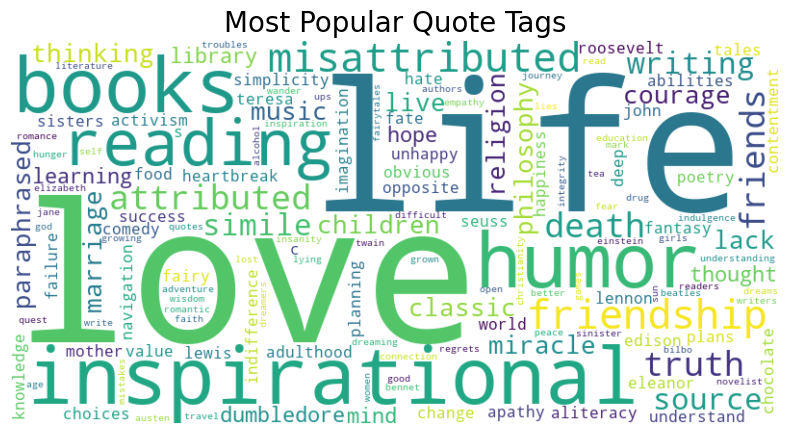

In [18]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import os

# Beginner Tip: We need the data from the previous steps!
# This check handles the case where you might have run this cell without running the scraping code first.
if 'all_df' not in locals():
    if os.path.exists('all_quotes.csv'):
        print("Variable 'all_df' not found. Loading from 'all_quotes.csv'...")
        all_df = pd.read_csv('all_quotes.csv')
    else:
        print("❌ Error: No data found!")
        print("Please run 'Step 5' (Scraping Loop) in this notebook first to collect the data.")
        # Create a dummy df so the code below doesn't crash immediately with NameError
        all_df = pd.DataFrame(columns=['tags'])

if not all_df.empty and 'tags' in all_df.columns:
    # Combine all tags into a single string
    # We use str(tag) to handle potential numbers or missing values gracefully
    text = " ".join(str(tag) for tag in all_df['tags'].dropna())

    if text.strip():
        # Create the wordcloud object
        wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)

        # Display the generated image:
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title("Most Popular Quote Tags", fontsize=20)
        plt.show()
    else:
        print("⚠️ No tags were found to visualize.")
else:
    print("⚠️ DataFrame is empty or missing 'tags' column. Did the scraping finish successfully?")

### 2. Mini-Game: Who Said It?
Test your knowledge (or luck!) with a simple interactive quiz based on the data you scraped.

In [20]:
import random

def start_quiz():
    # Pick a random row from our dataframe
    random_row = all_df.sample(1).iloc[0]
    quote = random_row['quote']
    correct_author = random_row['author']
    
    # Get 3 other random authors for multiple choice
    distractors = all_df[all_df['author'] != correct_author]['author'].sample(3).tolist()
    options = distractors + [correct_author]
    random.shuffle(options)
    
    print("\n" + "="*50)
    print("🕵️  MYSTERY QUOTE  🕵️")
    print("="*50)
    print(f'"{quote}"')
    print("-" * 50)
    print("Who said this?")
    
    for i, option in enumerate(options):
        print(f"{i+1}. {option}")
        
    try:
        user_choice = int(input("\nEnter the number of your guess: "))
        if options[user_choice-1] == correct_author:
            print("\n✅ Correct! You're a pro!")
        else:
            print(f"\n❌ Oops! It was actually {correct_author}.")
    except (ValueError, IndexError):
        print("\n⚠️ Invalid input. Game over!")

# Run the game
start_quiz()


🕵️  MYSTERY QUOTE  🕵️
"Anyone who thinks sitting in church can make you a Christian must also think that sitting in a garage can make you a car."
--------------------------------------------------
Who said this?
1. Garrison Keillor
2. Marilyn Monroe
3. John Lennon
4. Steve Martin

✅ Correct! You're a pro!
